# TensorFlow - RNN
## Eduardo Gomes Sanglard - IAA 2022
### Laboratório de Inteligência Artifical - Frameworks de IA

- RNN e Classificação de Textos - Senoidal : Predição de Série Temporal
- RNN e Classificação de Textos - Passageiros : Predição de Série Temporal
- RNN e Classificação de Textos - IMDB : Classificação de reviews
- RNN e Classificação de Textos - SPAM : Classificação de e-mails
- RNN e Classificação de Textos - Shakespeare: Geração de texto

Link para este notebook no Google Colab
https://drive.google.com/file/d/1BRs1_p0i2AhNfurArQOpTe7nojz2U6Rp/view?usp=sharing

Imports

In [1]:
import math, os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Embedding, LSTM, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer

tf.__version__

'2.12.0'

## Série temporal com senoidal

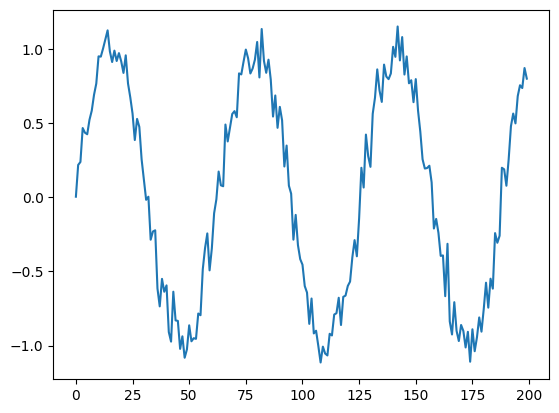

In [2]:
series = np.sin(0.1*np.arange(200)) + np.random.randn(200)*0.1
plt.plot(series)
plt.show()

In [3]:
T = 10 # tamanho da janela
D = 1 # quantidade de dados
X = []
Y = []
for t in range(len(series)-T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)
X = np.array(X).reshape(-1, T, 1) # Fica N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape: ", X.shape, " Y.shape: ", Y.shape)

X.shape:  (190, 10, 1)  Y.shape:  (190,)


In [4]:
i = Input(shape=(T, 1))
x = SimpleRNN(5, activation="relu")(i)
x = Dense(1)(x)
model = Model(i, x)

In [5]:
model.compile(
loss="mse",
optimizer=Adam(learning_rate=0.1)
)

In [6]:
r = model.fit(
X[:-N//2], Y[:-N//2],
epochs=80,
validation_data=(X[-N//2:], Y[-N//2:])
)

Epoch 1/80
3/3 [==============================] - 9s 270ms/step - loss: 1.2293 - val_loss: 0.0828
Epoch 2/80
3/3 [==============================] - 0s 45ms/step - loss: 0.0683 - val_loss: 0.0951
Epoch 3/80
3/3 [==============================] - 0s 115ms/step - loss: 0.0592 - val_loss: 0.0556
Epoch 4/80
3/3 [==============================] - 0s 41ms/step - loss: 0.0592 - val_loss: 0.0827
Epoch 5/80
3/3 [==============================] - 0s 76ms/step - loss: 0.0693 - val_loss: 0.0617
Epoch 6/80
3/3 [==============================] - 0s 90ms/step - loss: 0.0480 - val_loss: 0.0533
Epoch 7/80
3/3 [==============================] - 0s 94ms/step - loss: 0.0507 - val_loss: 0.0562
Epoch 8/80
3/3 [==============================] - 0s 65ms/step - loss: 0.0456 - val_loss: 0.0530
Epoch 9/80
3/3 [==============================] - 0s 74ms/step - loss: 0.0407 - val_loss: 0.0456
Epoch 10/80
3/3 [==============================] - 0s 62ms/step - loss: 0.0371 - val_loss: 0.0385
Epoch 11/80
3/3 [==========

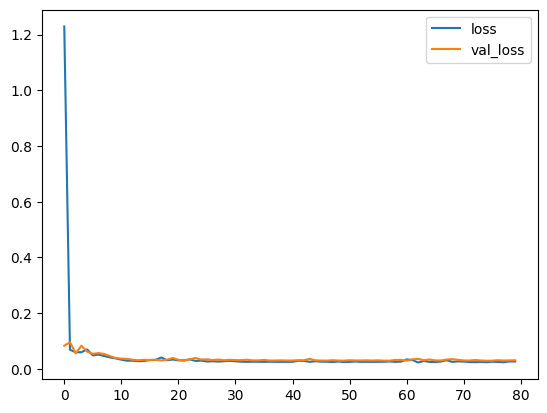

In [7]:
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.legend()

In [8]:
validation_target = Y[-N//2:]
validation_predictions = []
i = -N//2
while len(validation_predictions) < len(validation_target):
  p = model.predict( X[i].reshape(1, -1, 1))[0, 0]
  i += 1
  validation_predictions.append(p)

1/1 [==============================] - 0s 20ms/step


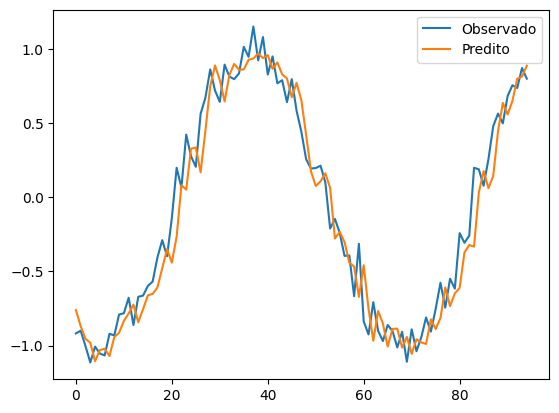

In [9]:
plt.plot(validation_target, label="Observado")
plt.plot(validation_predictions, label="Predito")
plt.legend()

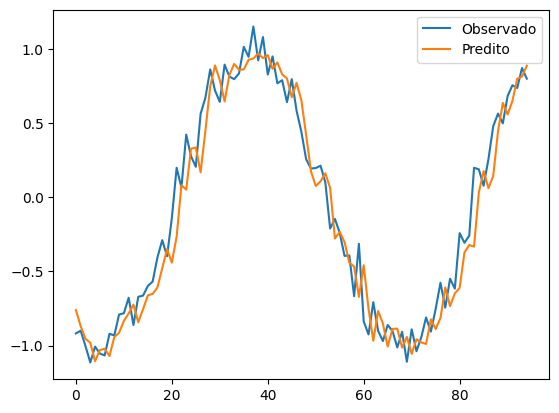

In [10]:
plt.plot(validation_target, label="Observado")
plt.plot(validation_predictions, label="Predito")
plt.legend()

## Dataset Passageiros
Carga dos dados

In [11]:
!wget http://www.razer.net.br/datasets/airline-passengers.csv

--2023-05-01 03:44:33--  http://www.razer.net.br/datasets/airline-passengers.csv
Resolving www.razer.net.br (www.razer.net.br)... 178.128.150.229
Connecting to www.razer.net.br (www.razer.net.br)|178.128.150.229|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/csv]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2023-05-01 03:44:33 (244 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]



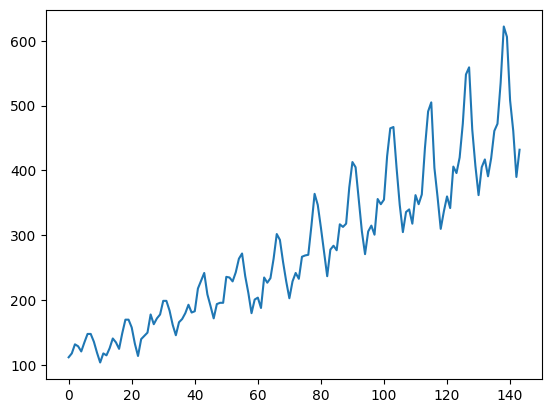

In [12]:
df = pd.read_csv("airline-passengers.csv", usecols=[1])
df.head()
plt.plot(df)
plt.show()

Pré-Processamento

- tamanho da base de treino – 67% do total

In [13]:
series = df.values
series = series.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
series = scaler.fit_transform(series)
train_size = int(len(series) * 0.67)

Conversão da série em dataset

In [14]:
T = 10
D = 1
X = []
Y = []
for t in range(len(series)-T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)
X = np.array(X).reshape(-1, T, 1) # Fica N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape: ", X.shape, " Y.shape: ", Y.shape)

X.shape:  (134, 10, 1)  Y.shape:  (134, 1)


Criação do modelo

In [15]:
i = Input(shape=(T, 1))
x = SimpleRNN(5, activation=None)(i)
# x = SimpleRNN(5, activation="relu")(i)
# x = SimpleRNN(5)(i) # tanh por default
x = Dense(1)(x)
model = Model(i, x)

Compilação e ajuste do modelo

In [16]:
model.compile(loss="mse",optimizer=Adam(learning_rate=0.1))
r = model.fit(X[:train_size], Y[:train_size],epochs=80,validation_data=(X[-train_size:], Y[-train_size:]))

Epoch 1/80
3/3 [==============================] - 1s 103ms/step - loss: 0.3404 - val_loss: 0.1014
Epoch 2/80
3/3 [==============================] - 0s 25ms/step - loss: 0.0357 - val_loss: 0.0100
Epoch 3/80
3/3 [==============================] - 0s 20ms/step - loss: 0.0185 - val_loss: 0.0140
Epoch 4/80
3/3 [==============================] - 0s 26ms/step - loss: 0.0145 - val_loss: 0.0559
Epoch 5/80
3/3 [==============================] - 0s 25ms/step - loss: 0.4529 - val_loss: 0.4016
Epoch 6/80
3/3 [==============================] - 0s 25ms/step - loss: 0.1660 - val_loss: 0.0217
Epoch 7/80
3/3 [==============================] - 0s 25ms/step - loss: 0.0168 - val_loss: 0.0378
Epoch 8/80
3/3 [==============================] - 0s 19ms/step - loss: 0.0393 - val_loss: 0.0720
Epoch 9/80
3/3 [==============================] - 0s 24ms/step - loss: 0.0252 - val_loss: 0.0489
Epoch 10/80
3/3 [==============================] - 0s 28ms/step - loss: 0.0268 - val_loss: 0.0445
Epoch 11/80
3/3 [===========

Plot função de perda

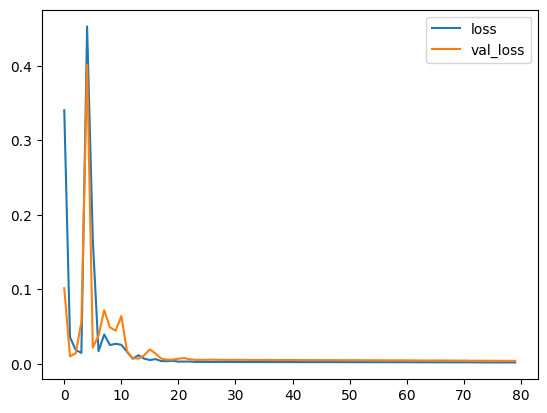

In [17]:
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.legend()

1º step

1/1 [==============================] - 0s 21ms/step


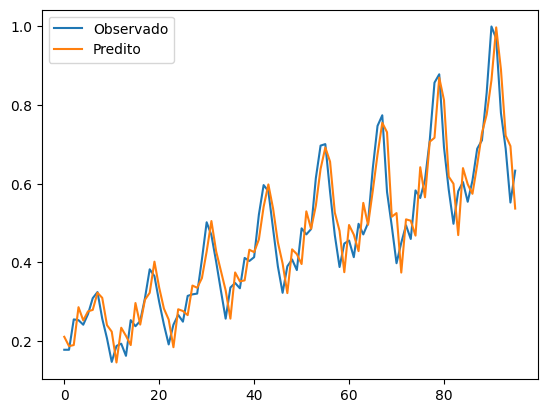

In [18]:
validation_target = Y[-train_size:]
validation_predictions = []
i = -train_size
while len(validation_predictions) < len(validation_target):
  p = model.predict( X[i].reshape(1, -1, 1))[0, 0]
  i += 1
  validation_predictions.append(p)
plt.plot(validation_target, label="Observado")
plt.plot(validation_predictions, label="Predito")
plt.legend()

Multi-Step

1/1 [==============================] - 0s 27ms/step


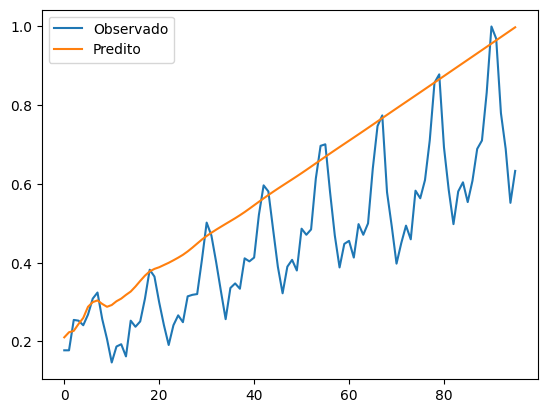

In [19]:
validation_target = Y[-train_size:]
validation_predictions = []
last_x = X[-train_size]
while len(validation_predictions) < len(validation_target):
  p = model.predict( last_x.reshape(1, -1, 1))[0, 0]
  validation_predictions.append(p)
  last_x = np.roll(last_x, -1)
  last_x[-1] = p
plt.plot(validation_target, label="Observado")
plt.plot(validation_predictions, label="Predito")
plt.legend()

## IMDB : Classificação de reviews

In [20]:
num_words = 20000 # número de palavras
maxlen = 200 # máximo palavras no review
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)
x_train.shape

17464789/17464789 [==============================] - 0s 0us/step


(25000,)

In [21]:
x_train

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 82

In [22]:
print(len(x_train[0]), len(x_train[1]))

218 189


In [23]:
x_train = pad_sequences(x_train, maxlen=maxlen)
print(len(x_train[0]), len(x_train[1]))

200 200


In [24]:
x_test = pad_sequences(x_test, maxlen=maxlen)
print(len(x_test[0]), len(x_test[1]))

200 200


In [25]:
# recebe como entrada maxlen palavras
i = Input(shape=(x_train.shape[1], ))
# com textos precisa da camada de
# - representação numérica das palavras
# num_words palavras e 128 características para representar
# cada palavra (colunas)
# Não tem relação com a quantidade de unidades da LSTM
x = Embedding(input_dim=num_words, output_dim=128)(i)
x = LSTM(units=128, activation="tanh")(x)
x = Dense(units=1, activation="sigmoid")(x)
model = Model(i, x)

In [26]:
# para RNN melhor rmsprop
model.compile(optimizer="rmsprop", loss="binary_crossentropy",
metrics=["accuracy"])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 128)          2560000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________


In [27]:
epochs = 10
r = model.fit(x_train, y_train, epochs=epochs, batch_size=128)

Epoch 1/10
196/196 [==============================] - 32s 147ms/step - loss: 0.5602 - accuracy: 0.7068
Epoch 2/10
196/196 [==============================] - 17s 87ms/step - loss: 0.3568 - accuracy: 0.8488
Epoch 3/10
196/196 [==============================] - 13s 67ms/step - loss: 0.2865 - accuracy: 0.8883
Epoch 4/10
196/196 [==============================] - 11s 56ms/step - loss: 0.2384 - accuracy: 0.9109
Epoch 5/10
196/196 [==============================] - 7s 36ms/step - loss: 0.2099 - accuracy: 0.9200
Epoch 6/10
196/196 [==============================] - 7s 33ms/step - loss: 0.1841 - accuracy: 0.9341
Epoch 7/10
196/196 [==============================] - 6s 31ms/step - loss: 0.1563 - accuracy: 0.9435
Epoch 8/10
196/196 [==============================] - 5s 23ms/step - loss: 0.1412 - accuracy: 0.9513
Epoch 9/10
196/196 [==============================] - 4s 23ms/step - loss: 0.1167 - accuracy: 0.9602
Epoch 10/10
196/196 [==============================] - 5s 26ms/step - loss: 0.1027 - a

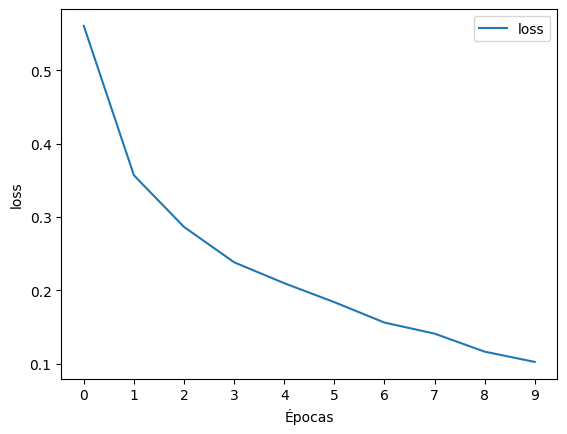

In [28]:
plt.plot( r.history["loss"], label="loss")
plt.xlabel("Épocas")
plt.ylabel("loss")
plt.xticks(np.arange(0, epochs, step=1))
plt.legend()

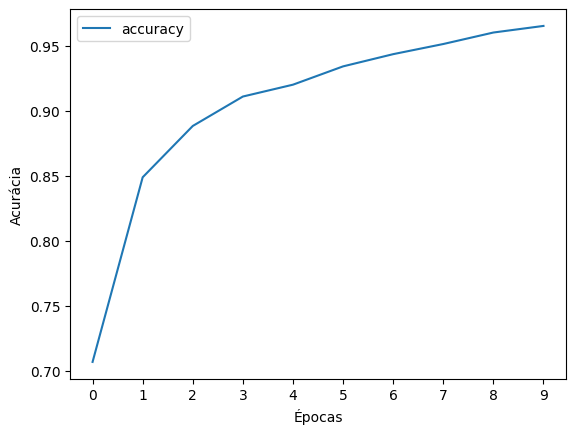

In [29]:
plt.plot( r.history["accuracy"], label="accuracy")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.xticks(np.arange(0, epochs, step=1))
plt.legend()


In [30]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(test_accuracy)

782/782 [==============================] - 4s 5ms/step - loss: 0.4768 - accuracy: 0.8593
0.859279990196228


In [31]:
texto = [[4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766]]
entrada = pad_sequences(texto, 200)
sent = np.round(model.predict(entrada))
print( "Positivo" if sent==1 else "Negativo" )

1/1 [==============================] - 0s 351ms/step
Negativo


## SPAM : Classificação de e-mails

In [32]:
!wget http://www.razer.net.br/datasets/spam.csv
df = pd.read_csv("spam.csv", encoding="ISO-8859-1")
df.head()
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
df.columns = ["labels", "data"]
df["b_labels"] = df["labels"].map({ "ham": 0, "spam" : 1})
y = df["b_labels"].values

--2023-05-01 03:47:26--  http://www.razer.net.br/datasets/spam.csv
Resolving www.razer.net.br (www.razer.net.br)... 178.128.150.229
Connecting to www.razer.net.br (www.razer.net.br)|178.128.150.229|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.1s    

2023-05-01 03:47:27 (3.52 MB/s) - ‘spam.csv’ saved [503663/503663]



In [33]:
x_train, x_test, y_train, y_test = train_test_split(df["data"],
y, test_size=0.33)

In [34]:
# Número máximo de palavras para considerar
# São consideradas as mais frequentes, as demais são
# ignoradas
num_words = 20000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(x_train)
sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)
word2index = tokenizer.word_index
V = len(word2index)
print("%s tokens" % V)

7211 tokens


In [35]:
data_train = pad_sequences(sequences_train)
T = data_train.shape[1] # tamanho da sequência
data_test = pad_sequences(sequences_test, maxlen=T)
print("data_train.shape: ", data_train.shape)
print("data_test.shape: ", data_test.shape)

data_train.shape:  (3733, 189)
data_test.shape:  (1839, 189)


In [36]:
D = 20 # tamanho do embedding, hiperparâmetro que pode ser escolhido
M = 15 # tamanho do hidden state
i = Input(shape=(T,))
x = Embedding(V+1, D)(i)
# x = LSTM(M)(x) # tirar o GlobalMaxPooling1D()
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(i, x)

In [37]:
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
epochs = 10
r = model.fit(data_train,y_train,epochs=epochs,validation_data=(data_test, y_test))

Epoch 1/10
117/117 [==============================] - 20s 141ms/step - loss: 0.5023 - accuracy: 0.8401 - val_loss: 0.3419 - val_accuracy: 0.8733
Epoch 2/10
117/117 [==============================] - 10s 81ms/step - loss: 0.3140 - accuracy: 0.8623 - val_loss: 0.2674 - val_accuracy: 0.8733
Epoch 3/10
117/117 [==============================] - 6s 46ms/step - loss: 0.2445 - accuracy: 0.8623 - val_loss: 0.2114 - val_accuracy: 0.8733
Epoch 4/10
117/117 [==============================] - 4s 35ms/step - loss: 0.1838 - accuracy: 0.8982 - val_loss: 0.1549 - val_accuracy: 0.9695
Epoch 5/10
117/117 [==============================] - 3s 28ms/step - loss: 0.1168 - accuracy: 0.9882 - val_loss: 0.1110 - val_accuracy: 0.9837
Epoch 6/10
117/117 [==============================] - 3s 24ms/step - loss: 0.0711 - accuracy: 0.9946 - val_loss: 0.0790 - val_accuracy: 0.9875
Epoch 7/10
117/117 [==============================] - 2s 17ms/step - loss: 0.0461 - accuracy: 0.9973 - val_loss: 0.0686 - val_accuracy: 0.9

In [38]:
model.compile(
loss="binary_crossentropy",
optimizer="adam",
metrics=["accuracy"]
)
epochs = 10
r = model.fit(
data_train,
y_train,
epochs=epochs,
validation_data=(data_test, y_test))

Epoch 1/10
117/117 [==============================] - 14s 94ms/step - loss: 0.0106 - accuracy: 0.9984 - val_loss: 0.0619 - val_accuracy: 0.9821
Epoch 2/10
117/117 [==============================] - 8s 69ms/step - loss: 0.0066 - accuracy: 0.9995 - val_loss: 0.0584 - val_accuracy: 0.9864
Epoch 3/10
117/117 [==============================] - 4s 29ms/step - loss: 0.0042 - accuracy: 0.9997 - val_loss: 0.0609 - val_accuracy: 0.9875
Epoch 4/10
117/117 [==============================] - 4s 37ms/step - loss: 0.0031 - accuracy: 0.9997 - val_loss: 0.0635 - val_accuracy: 0.9869
Epoch 5/10
117/117 [==============================] - 3s 25ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0653 - val_accuracy: 0.9869
Epoch 6/10
117/117 [==============================] - 3s 23ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0706 - val_accuracy: 0.9842
Epoch 7/10
117/117 [==============================] - 2s 17ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0774 - val_accuracy: 0.983

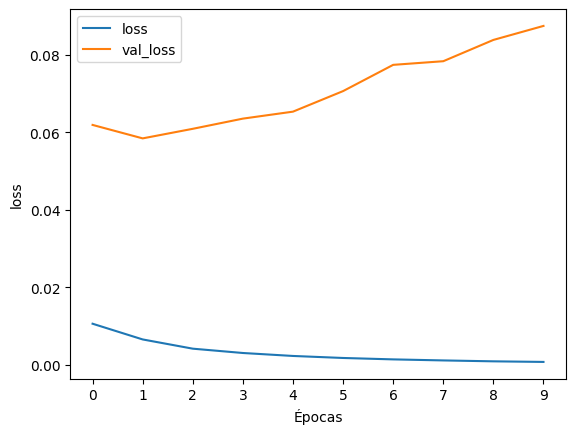

In [39]:
plt.plot( r.history["loss"], label="loss")
plt.plot( r.history["val_loss"], label="val_loss")
plt.xlabel("Épocas")
plt.ylabel("loss")
plt.xticks(np.arange(0, epochs, step=1))
plt.legend()

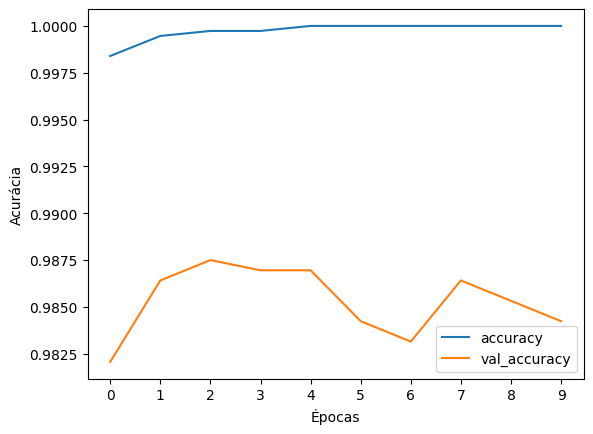

In [40]:
plt.plot( r.history["accuracy"], label="accuracy")
plt.plot( r.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.xticks(np.arange(0, epochs, step=1))
plt.legend()

In [41]:
texto = "Before I introduce myself do you like bitcoin"
seq_texto = tokenizer.texts_to_sequences([texto])
data_texto = pad_sequences(seq_texto, maxlen=T)
pred = model.predict(data_texto)
print(pred)
print ("SPAM" if pred >= 0.5 else "OK")

1/1 [==============================] - 0s 330ms/step
[[0.00040169]]
OK


## Shakespeare: Geração de texto

In [56]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt ')
# Leitura do texto
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# Tamanho do texto em número de caracteres
print(f'Tamanho do texto: {len(text)} caracteres')
# Primeiros 250 caracteres do texto
print(text[:250])
# Caracteres únicos
vocab = sorted(set(text)) 
print(f'{len(vocab)} caracters únicos')

Tamanho do texto: 1115394 caracteres
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

65 caracters únicos


Processamento do texto
Converte um caractere em um ID único

In [57]:
# Processamento do texto
# Converte um caractere em um ID único
ids_from_chars = tf.keras.layers.StringLookup(vocabulary=list(vocab), mask_token=None)

# Faz o contrário, converte os IDs em caracteres
chars_from_ids = tf.keras.layers.StringLookup(vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

# Função onde, dado uma lista de IDs, gera o texto
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

#### Gerar base de treino
- Exemplo : Para a palavra "Hello"
- Suponha seq_length = 4
- Então: Entrada "Hell" e Saída "ello"
- Tem que dividir o texto em pedaços de tamanho seq_length+1
- from_tensor_slices - cria um dataset com os dados

In [58]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8')) 
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Converte as sequências no tamanho desejado : seq_length+1
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)
for seq in sequences.take(5): 
  print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


Função onde, dado uma sequência "Hello", gera entrada e saída: "Hell" e "ello"

In [59]:
# Função onde, dado uma sequência "Hello", gera entrada e saída: "Hell" e "ello"
def split_input_target(sequence):
  input_text = sequence[:-1] 
  target_text = sequence[1:] 
  return input_text, target_text

# dataset contém as sequências contendo entrada e saída
dataset = sequences.map(split_input_target)

# Criar lotes de treinamento # Batch size
BATCH_SIZE = 64

# Tamanho do buffer para randomizar o dataset
BUFFER_SIZE = 10000
dataset = (
  dataset
  .shuffle(BUFFER_SIZE)
  .batch(BATCH_SIZE, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE)
  )

In [60]:
# Construir o modelo
# Tamanho do vocabulário em número de caracteres
vocab_size = len(vocab)
# Dimensão do Embedding
embedding_dim = 256
# Número de unidades RNN
rnn_units = 1024

In [61]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

Criação do modelo
Be sure the vocabulary size matches the `StringLookup` layers.

In [ ]:
model = MyModel(
    # Be sure the vocabulary size matches the `StringLookup` layers.
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

# Função de perda é sparse_categorical_crossentropy
# Modelo retorna Logits, sinaliza from_logits
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
# Compila o modelo
model.compile(optimizer='adam', loss=loss)
# Treinar
EPOCHS = 20
history = model.fit(dataset, epochs=EPOCHS)

Epoch 1/20
172/172 [==============================] - 16s 62ms/step - loss: 2.7151
Epoch 2/20
172/172 [==============================] - 12s 59ms/step - loss: 1.9888
Epoch 3/20
172/172 [==============================] - 15s 60ms/step - loss: 1.7070
Epoch 4/20
172/172 [==============================] - 13s 61ms/step - loss: 1.5459
Epoch 5/20
172/172 [==============================] - 13s 61ms/step - loss: 1.4474
Epoch 6/20
172/172 [==============================] - 12s 59ms/step - loss: 1.3801
Epoch 7/20
172/172 [==============================] - 12s 58ms/step - loss: 1.3273
Epoch 8/20
172/172 [==============================] - 12s 58ms/step - loss: 1.2825
Epoch 9/20
172/172 [==============================] - 12s 58ms/step - loss: 1.2417
Epoch 10/20
172/172 [==============================] - 12s 61ms/step - loss: 1.2020
Epoch 11/20
172/172 [==============================] - 12s 61ms/step - loss: 1.1617
Epoch 12/20
172/172 [==============================] - 12s 58ms/step - loss: 1.1207
E

Função de perda é sparse_categorical_crossentropy
Modelo retorna Logits, sinaliza from_logits

In [63]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
# Compila o modelo
model.compile(optimizer='adam', loss=loss)
# Treinar
EPOCHS = 20
history = model.fit(dataset, epochs=EPOCHS)

Epoch 1/20
172/172 [==============================] - 14s 62ms/step - loss: 0.6596
Epoch 2/20
172/172 [==============================] - 12s 60ms/step - loss: 0.5949
Epoch 3/20
172/172 [==============================] - 12s 60ms/step - loss: 0.5586
Epoch 4/20
172/172 [==============================] - 12s 61ms/step - loss: 0.5293
Epoch 5/20
172/172 [==============================] - 12s 61ms/step - loss: 0.5054
Epoch 6/20
172/172 [==============================] - 12s 60ms/step - loss: 0.4848
Epoch 7/20
172/172 [==============================] - 12s 59ms/step - loss: 0.4687
Epoch 8/20
172/172 [==============================] - 12s 59ms/step - loss: 0.4566
Epoch 9/20
172/172 [==============================] - 12s 59ms/step - loss: 0.4453
Epoch 10/20
172/172 [==============================] - 12s 59ms/step - loss: 0.4389
Epoch 11/20
172/172 [==============================] - 12s 61ms/step - loss: 0.4324
Epoch 12/20
172/172 [==============================] - 12s 61ms/step - loss: 0.4250
E

In [64]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [65]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

# Executar em um laço para gera o texto
start = time.time()
states = None
next_char = tf.constant(['ROMEO:']) 
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states) 
  result.append(next_char)

result = tf.strings.join(result)
end = time.time() 

print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80) 
print('\nRun time:', end - start)

ROMEO:
God grant me to a deviling splinter: Come, I say to thee;
Hig it infected this bone and worse,
And yet look back with grief that napkina eld's good fores
Began the sacrament: if this led flown prince,
And beseech your grace to fall, and afflict your grace,
It best as may be sworn or two of trial.
May that a state for things that means to peace.
We would have few'd her other house.

CORIOLANUS:
Proceed:
I will be hang'd my lord, imaged all your life,--from I earth,
That thou exist'st our day such sweets, in possessor.

KING EDWARD IV:
Yea, brother Richard, Lord Hastings, let the better fortune
To move like leaves banquent o' the city shake
Their corcenty Countivoliaus; I swear potter with her breath,
That makes the beggar there of York he cries!

WARWICK:
Poor Clifford! how often Margaret, give this new madam,
Dight no more to know our minds, and would wish me
To me innocence; and then reforce him
With death of heaven, bids us do mean: I
should not hear or Corioli back: 'tis good